# Evaluate the Effect of Temperature
See how the void growth rates and mobility terms change as a function of temperature

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import json

## Load Results
Each of the result folders in [the void tracking directory](../1_void-tracking) are named after the temperature and contain a file which contains the void growth and mobility functions.

In [2]:
param_order = ['alpha.0', 'alpha.1', 'beta.0', 'beta.1']  # The terms are always in the same order.

In [3]:
dynamics_terms = []
for path in Path('../1_void-tracking/output/').glob('8bitTIFF-*/growth-parameters-bayesian.json'):
    # Get the temperature
    temperature = float(path.parent.name.split("-")[-1][:-1])  # Directories are named [...]-[temp]C
    terms = {'temp': temperature}
    
    # Load the model parameters
    params = json.loads(path.read_text())
    for key, p in params.items():
        for name, v in zip(param_order, p['mean']):
            terms[f'{key}.{name}'] = v
        terms[f'{key}.covar'] = np.array(p['covar'])
    
    dynamics_terms.append(terms)
dynamics_terms = pd.DataFrame(dynamics_terms).sort_values('temp')

In [4]:
dynamics_terms

,temp,growth.alpha.0,growth.alpha.1,growth.beta.0,growth.beta.1,growth.covar,movement.alpha.0,movement.alpha.1,movement.beta.0,movement.beta.1,movement.covar
0,525.0,-0.001450,-0.000200,-1.609942,-0.120840,"[[1.8595693649908926e-08, -2.722691414035626e-...",-1.942456,-0.563750,0.034069,0.014361,"[[0.0003055118416637787, -8.074296974155348e-0..."
4,550.0,-0.008861,0.000457,-1.331849,0.017572,"[[8.540584149702393e-06, -1.788994410471359e-0...",-3.188169,-0.112190,0.196675,-0.000802,"[[0.007519228487115018, -0.001532517494622713,..."
2,575.0,-0.002350,0.000414,-1.451770,-0.128595,"[[5.3389959707970275e-08, -6.069322330222907e-...",-2.568299,-0.417078,0.070645,0.000184,"[[0.0006760178350983613, -9.7439017565279e-05,..."
5,600.0,-0.000073,0.000341,-1.374467,0.027061,"[[8.137948657002262e-07, -1.643827222676969e-0...",-2.369049,0.147860,0.114479,-0.007247,"[[0.00041133672465144084, -6.950711114459888e-..."
3,625.0,-0.001051,0.000855,-2.113991,-0.001185,"[[1.830293401357427e-09, -3.512344634530781e-1...",-2.368642,-0.236065,0.098474,0.005269,"[[5.273733429573253e-05, -1.0526067930616075e-..."
1,650.0,0.002947,0.000313,-1.770134,-0.006092,"[[5.983061443276663e-08, -6.230735345252651e-0...",-0.706177,0.115668,0.167349,-0.005368,"[[0.00043047754117786936, -4.535436514732648e-..."


## Plot the Effect of Temperature on Growth
See if there is a consistent trend.

Compute the error bar for the growth rate knowing that the terms are additive

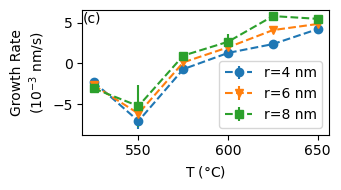

In [5]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

for r, m in zip([4, 6, 8], 'ovs'):
    y = dynamics_terms['growth.alpha.0'] + r * dynamics_terms['growth.alpha.1']
    yerr = np.sqrt(
        dynamics_terms['growth.covar'].apply(lambda x: x[0, 0]) + 
        dynamics_terms['growth.covar'].apply(lambda x: x[1, 1]) * r ** 2 +
        2 * r * dynamics_terms['growth.covar'].apply(lambda x: x[0, 1])
    )
    
    ax.errorbar(dynamics_terms['temp'],
                y=y * 1e3, yerr=yerr * 1e3,
               fmt=f'--{m}', label=f'r={r} nm')

ax.text(0, 0.9, '(c)', transform=ax.transAxes, fontsize=10)
ax.set_xlabel('T ($\\degree$C)')
ax.set_ylabel('Growth Rate\n($10^{-3}$ nm/s)')
ax.legend()
#ax.set_ylim(-0.02, 0.02)

fig.tight_layout()
fig.savefig('figures/growth-vs-temperature.png', dpi=320)

Notes:
- We are less confident in the 525C voids because they are in a different imaging mode. Mention that in the report

## Plot effect on Critical Radius
The critical radius is where the growth rate is zero

$r_{crit} = - \alpha_0 / \alpha_1$

We can express the variance of this term as: 

$\sigma_{r_{crit}}^2 = \left(\frac{\alpha_0}{\alpha_1}\right)^2 \left[ 
   \left(\frac{\sigma_{\alpha_0}}{\alpha_0} \right) ^ 2 +
   \left(\frac{\sigma_{\alpha_1}}{\alpha_1} \right) ^ 2 -
   2 \frac{\sigma_{\alpha_0\alpha_1}}{\alpha_0\alpha_1}
\right]$

through [propogation of uncertainty](https://en.wikipedia.org/wiki/Propagation_of_uncertainty#Example_formulae)

In [6]:
dynamics_terms['radius_crit'] = -dynamics_terms['growth.alpha.0'] / dynamics_terms['growth.alpha.1']

In [7]:
dynamics_terms['radius_crit-std'] = dynamics_terms['radius_crit'] ** 2 * (
    dynamics_terms['growth.covar'].apply(lambda x: x[0, 0]) / dynamics_terms['growth.alpha.0'] ** 2 +
    dynamics_terms['growth.covar'].apply(lambda x: x[1, 1]) / dynamics_terms['growth.alpha.1'] ** 2 -
    2 * dynamics_terms['growth.covar'].apply(lambda x: x[0, 1]) / dynamics_terms['growth.alpha.1'] / dynamics_terms['growth.alpha.0']
)
dynamics_terms['radius_crit-std'] = np.sqrt(dynamics_terms['radius_crit-std'])

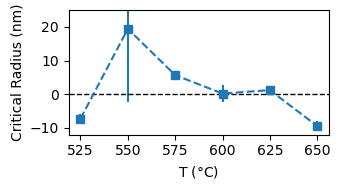

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.))

ax.errorbar(dynamics_terms['temp'],
            y=dynamics_terms['radius_crit'],
            yerr=dynamics_terms['radius_crit-std'], 
            fmt=f'--{m}', label=f'r={r} nm')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0, 0], 'k--', lw=1)

ax.set_ylim(-12, 25)
ax.set_xlabel('T ($\\degree$C)')
ax.set_ylabel('Critical Radius (nm)')

fig.tight_layout()
fig.savefig('figures/critical-radius-vs-temperature.png', dpi=320)

I wonder what a negative critical radius means? All voids will grow continually? 